In [2]:
import pandas as pd
import numpy as np
from sys import path
from src import util
from src.transformation import transform
from src import config
from src import subject_manipulation
from textwrap import wrap
from typing import Tuple, List
from src.config import SUBJECT_DF_PATH, BLANK_ANSWER_LABEL, DELETION_ANSWER_LABEL, CANCELLED_LABEL, DIFFICULTIES, \
    MATH_SUBJECTS, COMPUTING_SUBJECTS, HUMAN_SUBJECTS, TECHNOLOGY_SUBJECTS
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
import matplotlib.patches as mpatches
import matplotlib.ticker as mtick


In [3]:
subject_df = subject_manipulation.get_processed_subject_df(SUBJECT_DF_PATH)
dfs_dict_course = util.get_dict_all_years(filter_by_course=True)

In [4]:
def remove_absent_students(dfs):
    for x in dfs.keys():
        df = dfs[x]
        util.map_presence(df)
        dfs[x] = util.filter_present_students(df)
    return dfs

dfs_dict_course = remove_absent_students(dfs_dict_course)

In [5]:
def get_display_df(year: int, input_df: pd.DataFrame,
                   subject_df: pd.DataFrame) -> Tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    ### this shouldn't stay here
    subject_df_year = subject_df.loc[subject_df['ano'] == year].copy()
    
    year_subjects = util.get_subjects(subject_df_year)
    input_df = util.add_all_score_categories(input_df, subject_df_year, True, 
                                             year_subjects, util.get_subject_valid_questions)
    
    num_questions = []
    mean_acertos_by_subject = []
    std_acertos_by_subject = []
    column_zero_subject = []
    column_geq_one_subject = []
    column_all_subject = []
    num_alunos = input_df.shape[0]

    for subject in year_subjects:
        subject_questions = util.get_subject_valid_questions(subject, 
                                                                 subject_df_year,
                                                                 input_df,
                                                                 just_objective=True)
        num_obj_subject_questions = len(subject_questions)
    
    
    
        mean_acertos_subject = input_df[f"ACERTOS_OBJ_{subject}"].mean()
    
        std_acertos_subject = input_df[f"ACERTOS_OBJ_{subject}"].std()
    
        zero_subject_percentage = list(input_df[f"ACERTOS_OBJ_{subject}"]).count(0) * 100 / num_alunos
    
        geq_one_subject_percentage = list(input_df[f"ACERTOS_OBJ_{subject}"] >= 1).count(True) * 100 / num_alunos
        
        all_subject_percentage = list(input_df[f"ACERTOS_OBJ_{subject}"] == num_obj_subject_questions).count(True) * 100 / num_alunos
        
        if num_obj_subject_questions > 0:
            num_questions.append(num_obj_subject_questions)
            mean_acertos_by_subject.append(mean_acertos_subject)
            std_acertos_by_subject.append(std_acertos_subject)
            column_zero_subject.append(zero_subject_percentage)
            column_geq_one_subject.append(geq_one_subject_percentage)
            column_all_subject.append(all_subject_percentage)
        else:
            num_questions.append(0)
            mean_acertos_by_subject.append(None)
            std_acertos_by_subject.append(None)
            column_zero_subject.append(None)
            column_geq_one_subject.append(None)
            column_all_subject.append(None)

    subject_labels = [f"SCORE_OBJ_{x}" for x in year_subjects]

    mean_by_subject = input_df[subject_labels].mean().values

    data = np.array([mean_by_subject, num_questions]).T

    display_df = pd.DataFrame(data=data, index=year_subjects, 
                              columns=["Nota %", "Nº Questões"])
    display_df["Nº Questões"] = display_df["Nº Questões"].astype(int, errors="ignore")
    display_df["Média Acertos"] = mean_acertos_by_subject
    display_df["Desvio Padrão Acertos"] = std_acertos_by_subject
    display_df["% de Zeros"] = column_zero_subject

    display_df["% de Alunos que acertaram pelo menos uma questão"] = column_geq_one_subject
    display_df["% de Alunos que acertaram todas"] = column_all_subject

    display_df = display_df.sort_values(by=["Nota %"]).round(2)

    return display_df, input_df

In [6]:
def make_display_dfs(dfs_dict, subject_df):
    display_dfs_dict = {}
    for year in dfs_dict.keys():
        df_year = dfs_dict[year]
        display_df, df_year = get_display_df(year, df_year, subject_df)
        dfs_dict[year] = df_year
        display_dfs_dict[year] = display_df
    return display_dfs_dict, dfs_dict

display_dfs_course, dfs_dict_course = make_display_dfs(dfs_dict_course, subject_df)

In [7]:
def bar_graph_display_df(display_df):
    ax = plt.subplot(111)
    ax.barh(display_df.index, display_df["Nota %"], color="gray")
    ax.grid(axis = 'x', color ='white', linestyle='-')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    plt.title("Percentual de Acerto por Tema no ENADE")
    plt.xlabel("%")
    plt.xlim(0, 100)
    plt.show()
    
def make_radar_plot(series, title):
    values = list(series.values)
    labels = list(series.index)

# Number of variables we're plotting.
    num_vars = len(labels)

# Split the circle into even parts and save the angles
# so we know where to put each axis.
    angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()

# The plot is a circle, so we need to "complete the loop"
# and append the start value to the end.
    values += values[:1]
    angles += angles[:1]

# ax = plt.subplot(polar=True)
    fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))

# Draw the outline of our data.
    ax.plot(angles, values, color='#1aaf6c', linewidth=1)
# Fill it in.
    ax.fill(angles, values, color='#1aaf6c', alpha=0.25)

# Fix axis to go in the right order and start at 12 o'clock.
    ax.set_theta_offset(np.pi / 2)
    ax.set_theta_direction(-1)

# Draw axis lines for each angle and label.

    ax.set_thetagrids(np.degrees(angles), labels)

# Go through labels and adjust alignment based on where
# it is in the circle.
    for label, angle in zip(ax.get_xticklabels(), angles):
        if angle in (0, np.pi):
            label.set_horizontalalignment('center')
        elif 0 < angle < np.pi:
              label.set_horizontalalignment('left')
        else:
              label.set_horizontalalignment('right')

# Ensure radar goes from 0 to 100.
    ax.set_ylim(0, 100)
# You can also set gridlines manually like this:
# ax.set_rgrids([20, 40, 60, 80, 100])

# Set position of y-labels (0-100) to be in the middle
# of the first two axes.
    ax.set_rlabel_position(180 / num_vars)

# Add some custom styling.
# Change the color of the tick labels.
    ax.tick_params(colors='#222222')
# Make the y-axis (0-100) labels smaller.
    ax.tick_params(axis='y', labelsize=8)
# Change the color of the circular gridlines.
    ax.grid(color='#AAAAAA')
# Change the color of the outermost gridline (the spine).
    ax.spines['polar'].set_color('#222222')
# Change the background color inside the circle itself.
    ax.set_facecolor('#FAFAFA')

# Lastly, give the chart a title and give it some
# padding above the "Acceleration" label.
    ax.set_title(title, y=1.08)
    plt.show()

In [8]:
def get_sum_correct_questions_subjects(row: pd.Series, subjects: list) -> float:
    result = 0
    any_column_present = False
    for subject in subjects:
        column_name = f"ACERTOS_OBJ_{subject}"
        # this is needed in case this year's exame does not have any of the subects, like 'Ética'
        if column_name in row.index: 
            result += row[column_name]
            any_column_present = True # at least one subject is present
    if any_column_present:
        return result
    else:
        return None

def get_sum_questions_subjects(display_df: pd.DataFrame, subjects: list) -> int:
    result = 0
    for subject in subjects:
        if subject in display_df.index:
            result += display_df.loc[subject, "Nº Questões"]
    return result
    
def return_poscomp_score(df_original: pd.DataFrame, display_df: pd.DataFrame):
    
    df = df_original.copy()
    
    # Add columns
    categories = [MATH_SUBJECTS, COMPUTING_SUBJECTS, TECHNOLOGY_SUBJECTS, HUMAN_SUBJECTS]
    labels = ["Matemática", "Fundamentos da Computação", "Tecnologias da Computação", 
              "Contexto Social e Profissional"]
    labels_with_questions = []
    for subjects, label in zip(categories, labels):
        df[label] = df.apply(get_sum_correct_questions_subjects, args=(subjects,), axis=1)
        
        # get score by student
        num_questions_subjects = get_sum_questions_subjects(display_df, subjects) 
        if num_questions_subjects > 0:
            df[label] = (df[label] * 100) / num_questions_subjects
            labels_with_questions.append(label)
        
    # return mean score of the student's scores
    return df[labels_with_questions].mean() 

In [9]:
def display_data_by_subject(year: int, dfs_dict, display_dfs) -> pd.DataFrame:
    print(f"ANO de {year}")
    display_dfs[year] = display_dfs[year].loc[display_dfs[year]["Nº Questões"] != 0]
    bar_graph_display_df(display_dfs[year])
    poscomp_score = return_poscomp_score(dfs_dict[year], display_dfs[year])
    make_radar_plot(poscomp_score, "Percentual de Acerto por Área no ENADE")
    return display_dfs[year]

ANO de 2017


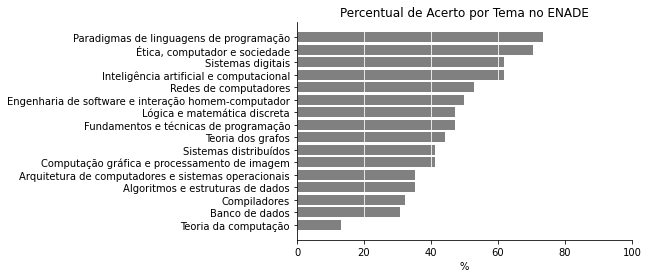

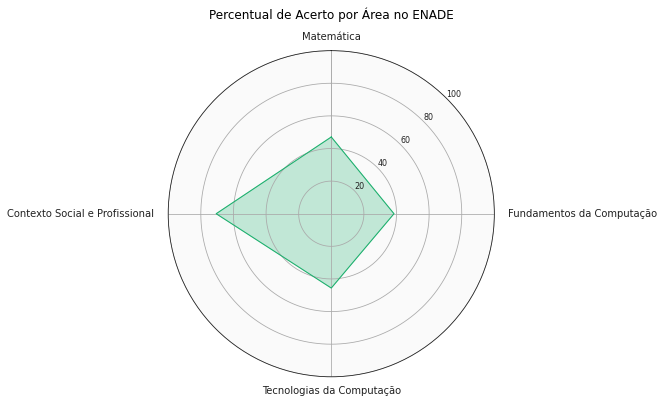

,Nota %,Nº Questões,Média Acertos,Desvio Padrão Acertos,% de Zeros,% de Alunos que acertaram pelo menos uma questão,% de Alunos que acertaram todas
Teoria da computação,13.24,2,0.26,0.45,73.53,26.47,0.00
Banco de dados,30.88,2,0.62,0.55,41.18,58.82,2.94
Compiladores,32.35,1,0.32,0.47,67.65,32.35,32.35
Algoritmos e estruturas de dados,35.29,4,1.41,1.08,23.53,76.47,2.94
Arquitetura de computadores e sistemas operacionais,35.29,3,1.06,0.81,23.53,76.47,5.88
Computação gráfica e processamento de imagem,41.18,1,0.41,0.50,58.82,41.18,41.18
Sistemas distribuídos,41.18,2,0.82,0.80,41.18,58.82,23.53
Teoria dos grafos,44.12,1,0.44,0.50,55.88,44.12,44.12
Fundamentos e técnicas de programação,47.06,1,0.47,0.51,52.94,47.06,47.06
Lógica e matemática discreta,47.06,1,0.47,0.51,52.94,47.06,47.06


In [10]:
year = 2017
display_data_by_subject(year, dfs_dict_course, display_dfs_course)

ANO de 2014


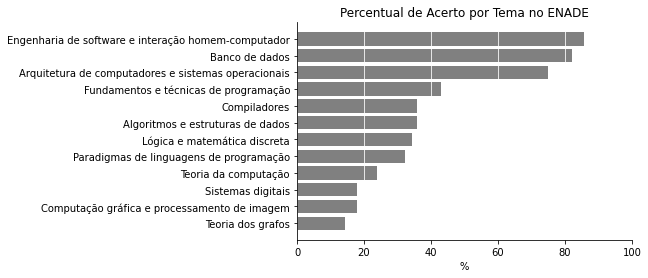

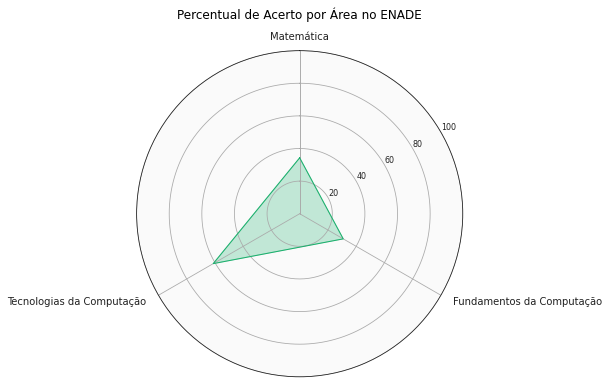

,Nota %,Nº Questões,Média Acertos,Desvio Padrão Acertos,% de Zeros,% de Alunos que acertaram pelo menos uma questão,% de Alunos que acertaram todas
Teoria dos grafos,14.29,2,0.29,0.53,75.00,25.00,3.57
Computação gráfica e processamento de imagem,17.86,1,0.18,0.39,82.14,17.86,17.86
Sistemas digitais,17.86,1,0.18,0.39,82.14,17.86,17.86
Teoria da computação,23.81,3,0.71,0.66,39.29,60.71,0.00
Paradigmas de linguagens de programação,32.14,1,0.32,0.48,67.86,32.14,32.14
Lógica e matemática discreta,34.29,5,1.71,1.12,14.29,85.71,0.00
Algoritmos e estruturas de dados,35.71,2,0.71,0.66,39.29,60.71,10.71
Compiladores,35.71,2,0.71,0.60,35.71,64.29,7.14
Fundamentos e técnicas de programação,42.86,1,0.43,0.50,57.14,42.86,42.86
Arquitetura de computadores e sistemas operacionais,75.00,1,0.75,0.44,25.00,75.00,75.00


In [11]:
year = 2014
display_data_by_subject(year, dfs_dict_course, display_dfs_course)

ANO de 2011


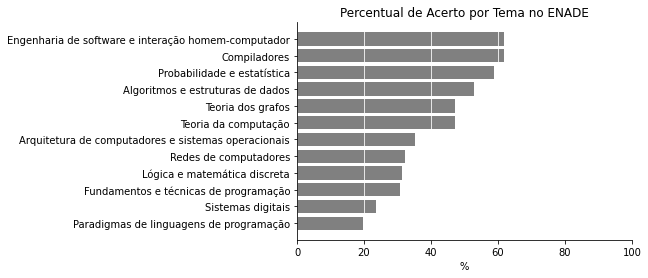

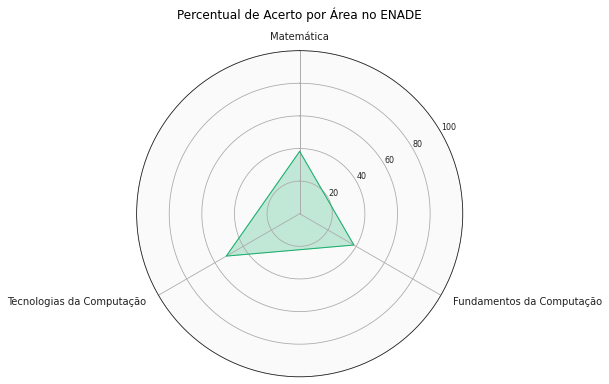

,Nota %,Nº Questões,Média Acertos,Desvio Padrão Acertos,% de Zeros,% de Alunos que acertaram pelo menos uma questão,% de Alunos que acertaram todas
Paradigmas de linguagens de programação,19.61,3,0.59,0.62,47.06,52.94,0.00
Sistemas digitais,23.53,1,0.24,0.44,76.47,23.53,23.53
Fundamentos e técnicas de programação,30.88,4,1.24,0.83,17.65,82.35,0.00
Lógica e matemática discreta,31.37,3,0.94,0.97,41.18,58.82,5.88
Redes de computadores,32.35,2,0.65,0.70,47.06,52.94,11.76
Arquitetura de computadores e sistemas operacionais,35.29,2,0.71,0.47,29.41,70.59,0.00
Teoria da computação,47.06,3,1.41,0.87,11.76,88.24,11.76
Teoria dos grafos,47.06,1,0.47,0.51,52.94,47.06,47.06
Algoritmos e estruturas de dados,52.94,5,2.65,1.00,0.00,100.00,0.00
Probabilidade e estatística,58.82,1,0.59,0.51,41.18,58.82,58.82


In [12]:
year = 2011
display_data_by_subject(year, dfs_dict_course, display_dfs_course)

ANO de 2008


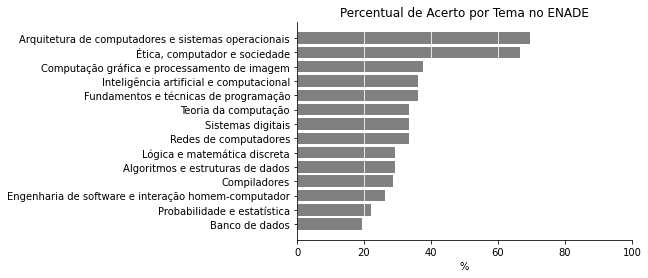

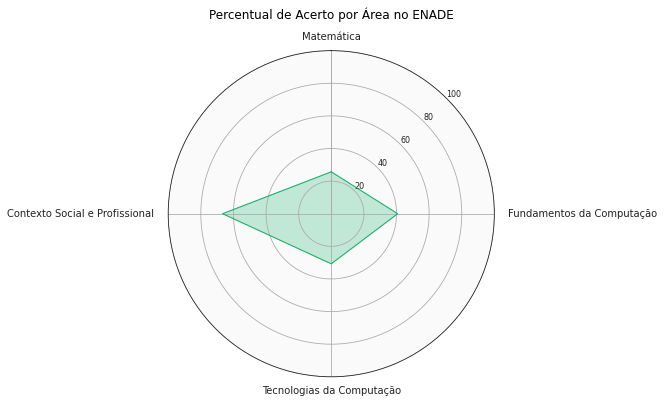

,Nota %,Nº Questões,Média Acertos,Desvio Padrão Acertos,% de Zeros,% de Alunos que acertaram pelo menos uma questão,% de Alunos que acertaram todas
Banco de dados,19.44,2,0.39,0.64,69.44,30.56,8.33
Probabilidade e estatística,22.22,2,0.44,0.56,58.33,41.67,2.78
Engenharia de software e interação homem-computador,26.39,2,0.53,0.70,58.33,41.67,11.11
Compiladores,28.70,3,0.86,0.76,36.11,63.89,0.00
Algoritmos e estruturas de dados,29.17,2,0.58,0.60,47.22,52.78,5.56
Lógica e matemática discreta,29.17,2,0.58,0.60,47.22,52.78,5.56
Redes de computadores,33.33,5,1.67,1.20,13.89,86.11,0.00
Sistemas digitais,33.33,2,0.67,0.48,33.33,66.67,0.00
Teoria da computação,33.33,2,0.67,0.68,44.44,55.56,11.11
Fundamentos e técnicas de programação,36.11,1,0.36,0.49,63.89,36.11,36.11


In [13]:
year = 2008
display_data_by_subject(year, dfs_dict_course, display_dfs_course)

ANO de 2005


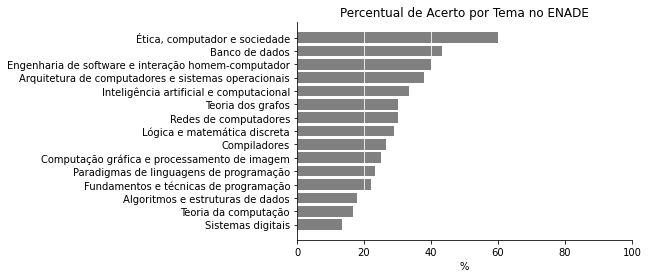

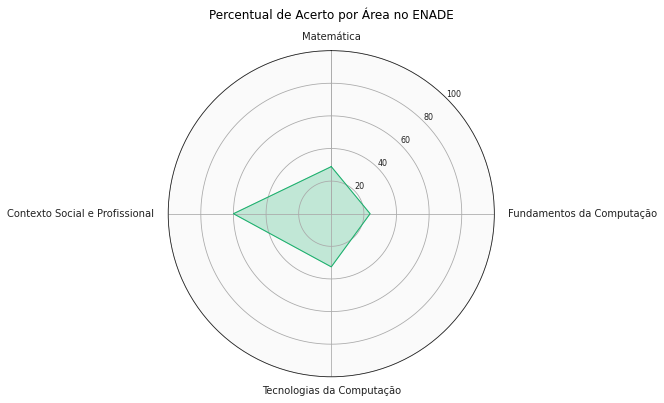

,Nota %,Nº Questões,Média Acertos,Desvio Padrão Acertos,% de Zeros,% de Alunos que acertaram pelo menos uma questão,% de Alunos que acertaram todas
Sistemas digitais,13.33,1,0.13,0.35,86.67,13.33,13.33
Teoria da computação,16.67,2,0.33,0.48,66.67,33.33,0.00
Algoritmos e estruturas de dados,17.78,3,0.53,0.63,53.33,46.67,0.00
Fundamentos e técnicas de programação,22.22,3,0.67,0.76,50.00,50.00,0.00
Paradigmas de linguagens de programação,23.33,1,0.23,0.43,76.67,23.33,23.33
Computação gráfica e processamento de imagem,25.00,2,0.50,0.57,53.33,46.67,3.33
Compiladores,26.67,1,0.27,0.45,73.33,26.67,26.67
Lógica e matemática discreta,28.89,3,0.87,0.68,30.00,70.00,0.00
Redes de computadores,30.00,2,0.60,0.67,50.00,50.00,10.00
Teoria dos grafos,30.00,1,0.30,0.47,70.00,30.00,30.00


In [14]:
year = 2005
display_data_by_subject(year, dfs_dict_course, display_dfs_course)

In [15]:
def display_all_years_nota(all_dfs: dict) -> pd.DataFrame:
    data = {"2005": all_dfs[2005]["Nota %"].copy(),
            "2008": all_dfs[2008]["Nota %"].copy(),
            "2011": all_dfs[2011]["Nota %"].copy(),
            "2014": all_dfs[2014]["Nota %"].copy(),
            "2017": all_dfs[2017]["Nota %"].copy()}
    return pd.DataFrame(data)

In [16]:
def first_sample(original_row, reverse=False):
    row = original_row.copy()
    if reverse:
        row = row.iloc[::-1]
        
    is_nan = row.isna()
    for index, value in enumerate(row.values):
        if not is_nan[index]:
            return value
    return ValueError("No value found")


def compute_gain(row, absolute) -> float:
    
    # in case we have only one sample
    if list(row.isna()).count(True) == 4:
        return None
    else:
        first_value = first_sample(row)
        last_value = first_sample(row, reverse=True)
        
        if absolute:
            gain = last_value - first_value
        else:
            gain = last_value * 100 / first_value - 100
        
        return gain
    

subject_score_by_year_course = display_all_years_nota(display_dfs_course)
absolute_gain = subject_score_by_year_course.apply(compute_gain, args=(True,), axis=1)
percentage_gain = subject_score_by_year_course.apply(compute_gain, args=(False,), axis=1)
subject_score_by_year_course["Ganho Absoluto"] = absolute_gain
subject_score_by_year_course["Ganho Percentual"] = percentage_gain
subject_score_by_year_course

,2005,2008,2011,2014,2017,Ganho Absoluto,Ganho Percentual
Algoritmos e estruturas de dados,17.78,29.17,52.94,35.71,35.29,17.51,98.481440
Arquitetura de computadores e sistemas operacionais,37.78,69.44,35.29,75.00,35.29,-2.49,-6.590789
Banco de dados,43.33,19.44,NaN,82.14,30.88,-12.45,-28.732979
Compiladores,26.67,28.70,61.76,35.71,32.35,5.68,21.297338
Computação gráfica e processamento de imagem,25.00,37.50,NaN,17.86,41.18,16.18,64.720000
Engenharia de software e interação homem-computador,40.00,26.39,61.76,85.71,50.00,10.00,25.000000
Fundamentos e técnicas de programação,22.22,36.11,30.88,42.86,47.06,24.84,111.791179
Inteligência artificial e computacional,33.33,36.11,NaN,NaN,61.76,28.43,85.298530
Lógica e matemática discreta,28.89,29.17,31.37,34.29,47.06,18.17,62.893735
Paradigmas de linguagens de programação,23.33,NaN,19.61,32.14,73.53,50.20,215.173596


In [17]:
def plot_bar_gain(subject_score_by_year, column, title):
    ax = plt.subplot(111)
    subject_score_by_year_gain = subject_score_by_year[column].copy()
    subject_score_by_year_gain = subject_score_by_year_gain.sort_values()
    subject_score_by_year_gain = subject_score_by_year_gain.dropna()
    ax.barh(subject_score_by_year_gain.index, subject_score_by_year_gain, color="gray")
    ax.grid(axis = 'x', color ='white', linestyle='-')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    plt.title(title)
    plt.show()

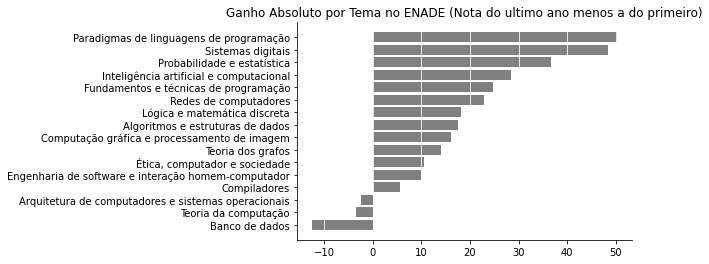

In [18]:
title = "Ganho Absoluto por Tema no ENADE (Nota do ultimo ano menos a do primeiro)"
plot_bar_gain(subject_score_by_year_course, "Ganho Absoluto", title)

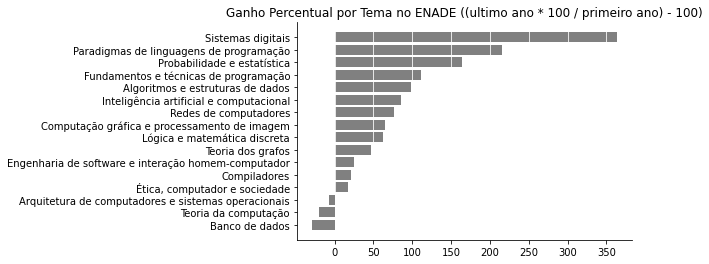

In [19]:
title = "Ganho Percentual por Tema no ENADE ((ultimo ano * 100 / primeiro ano) - 100)"
plot_bar_gain(subject_score_by_year_course, "Ganho Percentual", title)

In [20]:
"""Numero de questões respondidas por categoria considerando todos os anos
    
    contador para cada categoria iniciado em 0
    para cada prova
        para cada categoria
            multiplicar numero de presentes pelo numero de questões da categoria
            incrementar o contador da categoria
     """

def return_num_answered(display_dfs, original_dfs):
    num_questions_answered_dfs = []
    for year in display_dfs.keys():
        df = display_dfs[year]
        num_questions = df["Nº Questões"].astype(int).copy()
        num_questions *= original_dfs[year].shape[0]
        num_questions_answered_dfs.append(num_questions)
    num_questions_answered_df = pd.concat(num_questions_answered_dfs, axis=1)
    num_answered_by_category = num_questions_answered_df.fillna(0).sum(axis=1).sort_index()
    return num_answered_by_category

"""Numero de questões respondidas corretamente por categoria considerando todos os anos
    
    contador para cada categoria iniciado em 0
    para cada prova
        para cada categoria
            multiplicar numero de presentes pelo numero de questões acertadas da categoria
            incrementar o contador da categoria
     """

def return_num_correct(dfs, categories):
    columns = [f"ACERTOS_OBJ_{x}" for x in categories]
    correct_by_category  = pd.concat(dfs.values(), ignore_index=True)
    correct_by_category = correct_by_category[columns].sum(0).sort_index()
    return correct_by_category
    

def get_all_years_combined_df(display_dfs, dfs, categories):
    num_answered = return_num_answered(display_dfs, dfs)
    num_correct = return_num_correct(dfs, categories)
    num_correct.index = num_answered.index
    data_df = {"Questões Respondidas no total (Questões x Alunos)": num_answered,
               "Acertos no Total (Acertos x Alunos)": num_correct}
    score_df_category = pd.DataFrame(data_df)
    score_df_category["Nota %"] = score_df_category.iloc[:, 1]*100/score_df_category.iloc[:, 0]
    score_df_category.iloc[:, 0] =  score_df_category.iloc[:, 0].astype(int)
    score_df_category.iloc[:, 1] =  score_df_category.iloc[:, 1].astype(int)

    score_df_category["Nota %"] = score_df_category["Nota %"].round(2)
    
    return score_df_category.sort_values(by=["Nota %"])

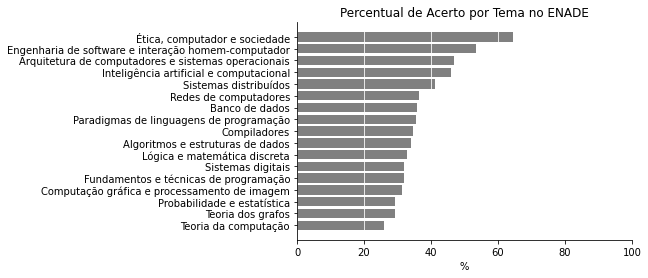

Dados da course considerando todos os anos


,Questões Respondidas no total (Questões x Alunos),Acertos no Total (Acertos x Alunos),Nota %
Teoria da computação,335,87,25.97
Teoria dos grafos,137,40,29.20
Probabilidade e estatística,89,26,29.21
Computação gráfica e processamento de imagem,194,61,31.44
Fundamentos e técnicas de programação,256,82,32.03
Sistemas digitais,181,58,32.04
Lógica e matemática discreta,387,127,32.82
Algoritmos e estruturas de dados,439,150,34.17
Compiladores,262,91,34.73
Paradigmas de linguagens de programação,143,51,35.66


In [21]:
all_years_combined_subject_course = get_all_years_combined_df(display_dfs_course, dfs_dict_course, 
                                                            util.get_subjects(subject_df))
bar_graph_display_df(all_years_combined_subject_course)
print("Dados da course considerando todos os anos")
all_years_combined_subject_course

In [22]:
def heatmap(data, row_labels, col_labels, ax=None,
            cbar_kw={}, cbarlabel="", **kwargs):
    """
    Create a heatmap from a numpy array and two lists of labels.

    Parameters
    ----------
    data
        A 2D numpy array of shape (N, M).
    row_labels
        A list or array of length N with the labels for the rows.
    col_labels
        A list or array of length M with the labels for the columns.
    ax
        A `matplotlib.axes.Axes` instance to which the heatmap is plotted.  If
        not provided, use current axes or create a new one.  Optional.
    cbar_kw
        A dictionary with arguments to `matplotlib.Figure.colorbar`.  Optional.
    cbarlabel
        The label for the colorbar.  Optional.
    **kwargs
        All other arguments are forwarded to `imshow`.
    """

    if not ax:
        ax = plt.gca(figsize=(220, 10))

    # Plot the heatmap
    im = ax.imshow(data, **kwargs)

    # Create colorbar
    
    cbar = ax.figure.colorbar(im, ax=ax, **cbar_kw)
    current_cmap = matplotlib.cm.get_cmap()
    current_cmap.set_bad(color='red')
    cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")

    # We want to show all ticks...
    ax.set_xticks(np.arange(data.shape[1]))
    ax.set_yticks(np.arange(data.shape[0]))
    # ... and label them with the respective list entries.
    ax.set_xticklabels(col_labels)
    ax.set_yticklabels(row_labels)

    # Let the horizontal axes labeling appear on top.
    ax.tick_params(top=True, bottom=False,
                   labeltop=True, labelbottom=False)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=-30, ha="right",
             rotation_mode="anchor")

    # Turn spines off and create white grid.
    for edge, spine in ax.spines.items():
        spine.set_visible(False)

    ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
    ax.set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
    ax.grid(which="minor", color="w", linestyle='-', linewidth=3)
    ax.tick_params(which="minor", bottom=False, left=False)

    return im, cbar


def annotate_heatmap(im, data=None, valfmt="{x:.2f}",
                     textcolors=["black", "white"],
                     threshold=None, **textkw):
    """
    A function to annotate a heatmap.

    Parameters
    ----------
    im
        The AxesImage to be labeled.
    data
        Data used to annotate.  If None, the image's data is used.  Optional.
    valfmt
        The format of the annotations inside the heatmap.  This should either
        use the string format method, e.g. "$ {x:.2f}", or be a
        `matplotlib.ticker.Formatter`.  Optional.
    textcolors
        A list or array of two color specifications.  The first is used for
        values below a threshold, the second for those above.  Optional.
    threshold
        Value in data units according to which the colors from textcolors are
        applied.  If None (the default) uses the middle of the colormap as
        separation.  Optional.
    **kwargs
        All other arguments are forwarded to each call to `text` used to create
        the text labels.
    """

    if not isinstance(data, (list, np.ndarray)):
        data = im.get_array()

    # Normalize the threshold to the images color range.
    if threshold is not None:
        threshold = im.norm(threshold)
    else:
        threshold = im.norm(data.max())/2.

    # Set default alignment to center, but allow it to be
    # overwritten by textkw.
    kw = dict(horizontalalignment="center",
              verticalalignment="center")
    kw.update(textkw)

    # Get the formatter in case a string is supplied
    if isinstance(valfmt, str):
        valfmt = matplotlib.ticker.StrMethodFormatter(valfmt)

    # Loop over the data and create a `Text` for each "pixel".
    # Change the text's color depending on the data.
    texts = []
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            kw.update(color=textcolors[int(im.norm(data[i, j]) > threshold)])
            if str(data[i,j]) == "--":
                text = im.axes.text(j, i, "-", None, **kw)
            else:
                text = im.axes.text(j, i, valfmt(data[i, j], None), **kw)
            texts.append(text)

    return texts

<string>:6: UserWarning: Warning: converting a masked element to nan.
/home/renan/.local/share/virtualenvs/KDD-HigherEduBR-KpG9-Zor/lib/python3.6/site-packages/numpy/core/_asarray.py:83: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


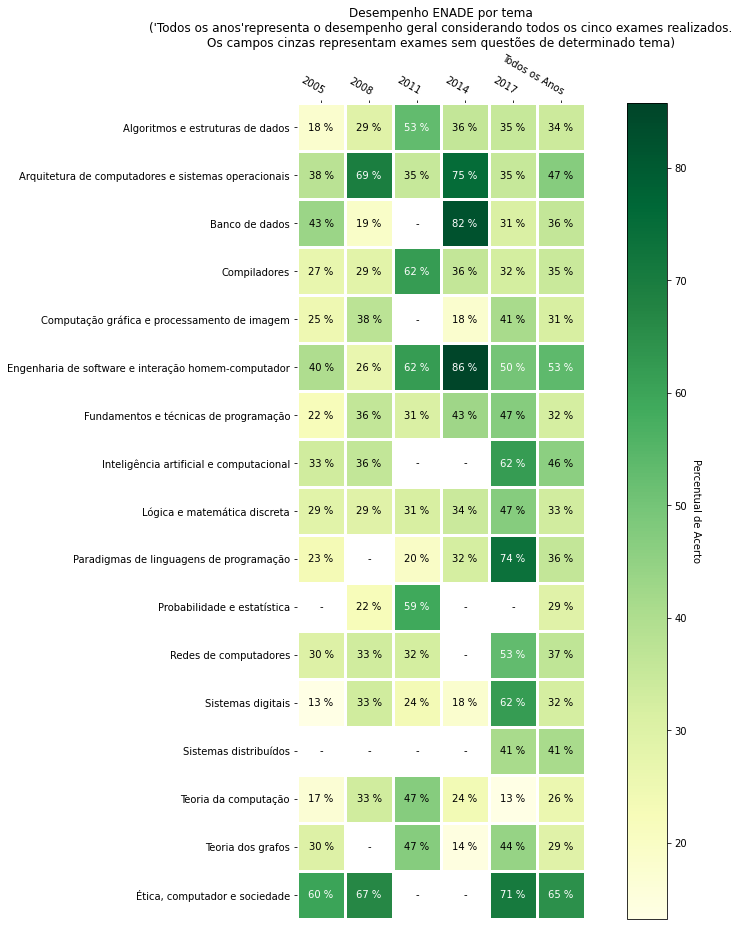

In [23]:
plt.rcParams["figure.figsize"]=15, 15
fig, ax = plt.subplots()


df_course_heatmap = display_all_years_nota(display_dfs_course)
df_course_heatmap["Todos os Anos"] = get_all_years_combined_df(display_dfs_course, 
                                                             dfs_dict_course, 
                                                             util.get_subjects(subject_df))["Nota %"]

#df = df.fillna("-")

im, cbar = heatmap(df_course_heatmap.values, df_course_heatmap.index, df_course_heatmap.columns, ax=ax,
                   cmap="YlGn", cbarlabel="Percentual de Acerto")
texts = annotate_heatmap(im, valfmt="{x:.0f} %")
    
#fig.tight_layout()
#plt.figure(figsize=(20,5))
im.cmap.set_bad("white")
plt.title(f"Desempenho ENADE por tema\n('Todos os anos'" 
          f"representa o desempenho geral considerando "
          f"todos os cinco exames realizados.\nOs campos "
          f"cinzas representam exames sem questões de determinado tema)")
plt.show()
plt.rcParams["figure.figsize"]=6,4


In [24]:
dfs_dict_br = util.get_dict_all_years(filter_by_course=False)

In [25]:
dfs_dict_br = remove_absent_students(dfs_dict_br)

In [26]:
#dfs_dict_br = remove_absent_students(dfs_dict_br)
display_dfs_br, dfs_dict_br = make_display_dfs(dfs_dict_br, subject_df)

Dados Nacionais


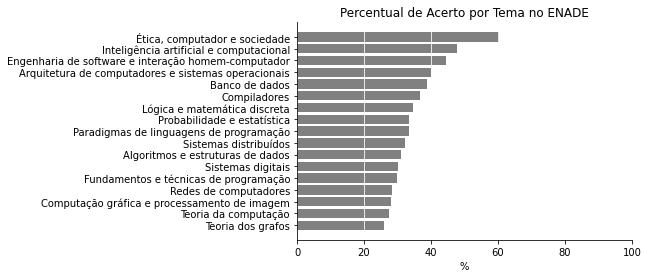

In [27]:
all_years_combined_subject_br = get_all_years_combined_df(display_dfs_br, dfs_dict_br, 
                                                          util.get_subjects(subject_df))
print("Dados Nacionais")
bar_graph_display_df(all_years_combined_subject_br)
#all_years_combined_subject_br

In [28]:
df_score_by_year_course = display_all_years_nota(display_dfs_course)
df_score_by_year_br = display_all_years_nota(display_dfs_br)

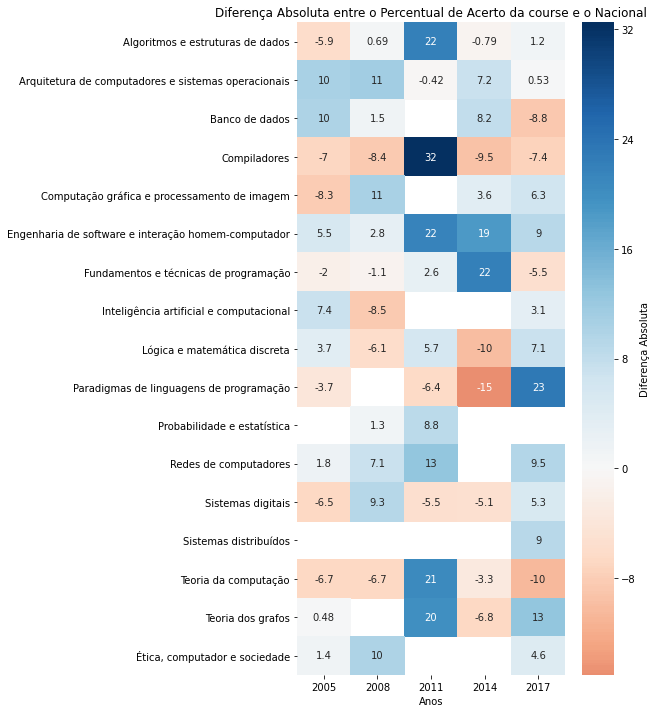

In [29]:
plt.figure(figsize=(6, 12))

sns.heatmap(df_score_by_year_course-df_score_by_year_br, center=0,cmap="RdBu", annot=True, cbar_kws={'label': 'Diferença Absoluta'})
plt.xlabel("Anos")
plt.title("Diferença Absoluta entre o Percentual de Acerto da course e o Nacional")
plt.show()

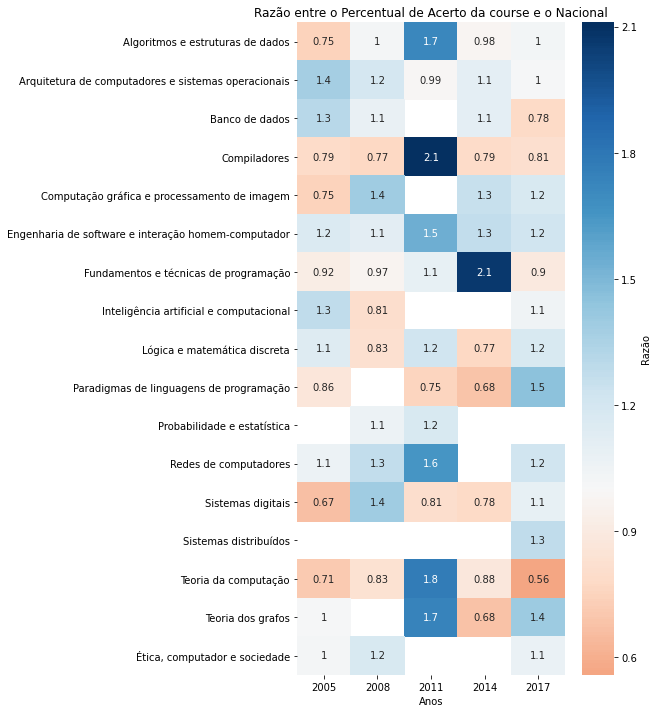

In [30]:
plt.figure(figsize=(6, 12))

sns.heatmap(df_score_by_year_course/df_score_by_year_br, center=1,cmap="RdBu", annot=True, cbar_kws={'label': 'Razão'})
plt.xlabel("Anos")
plt.title("Razão entre o Percentual de Acerto da course e o Nacional")
plt.show()

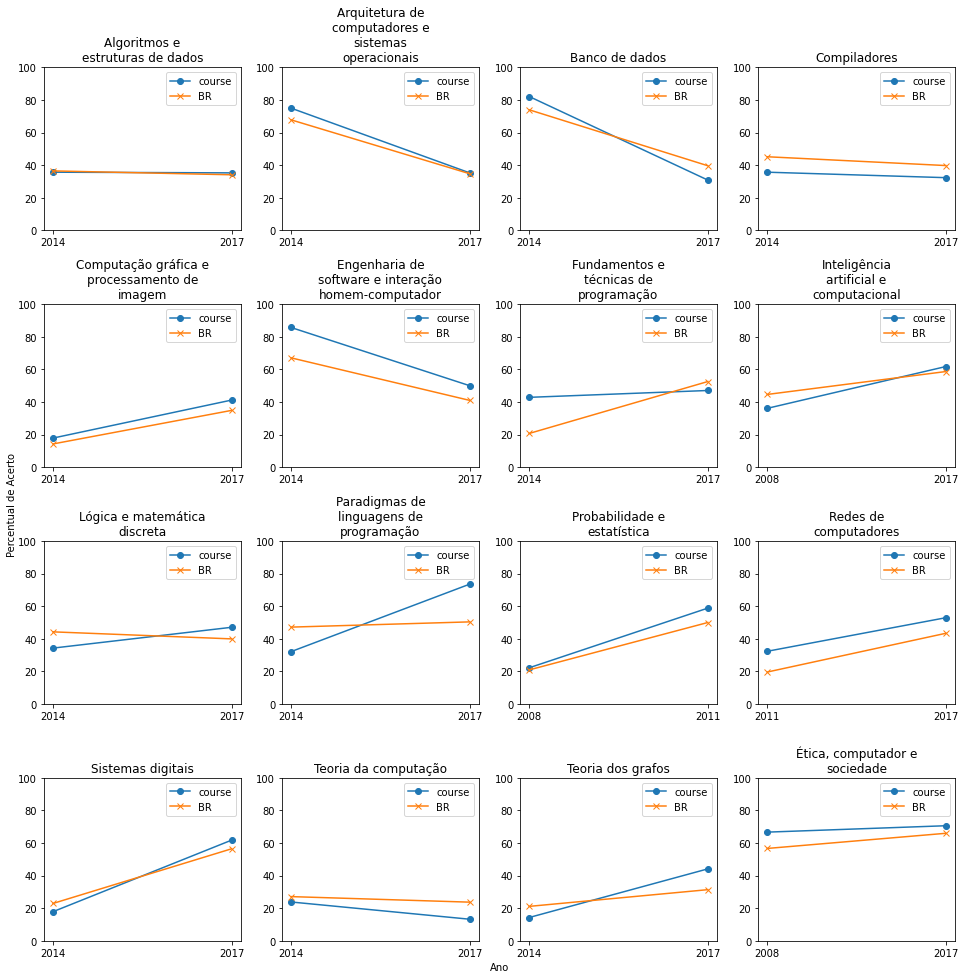

In [31]:
def get_last_two_scores(index, df):
    series = df.iloc[index]
    series = series.dropna()
    if series.shape[0] < 2:
        return None
    else:
        return series[-2:]
    
#plt.figure(0)

coordinates = []
for i in range(4):
    for j in range(4):
        coordinates.append((i, j))


fig = plt.figure(figsize=(14,14))
ax = fig.add_subplot(111) 
ax.spines['top'].set_color('none')
ax.spines['bottom'].set_color('none')
ax.spines['left'].set_color('none')
ax.spines['right'].set_color('none')
ax.tick_params(labelcolor='w', top=False, bottom=False, left=False, right=False)
ax.set_xlabel('Ano')
ax.set_ylabel('Percentual de Acerto')


coordinate_index = 1

if not df_score_by_year_course.index.equals(df_score_by_year_br.index):
    raise ValueError("Indexes should be the same on both dataframes")
for row in range(df_score_by_year_course.shape[0]):
    data_course = get_last_two_scores(row, df_score_by_year_course)
    if data_course is not None:
        data_br = get_last_two_scores(row, df_score_by_year_br)
        ax1 = fig.add_subplot(4,4,coordinate_index)
        plt.plot(data_course, "-o", label="course")
        plt.plot(data_br, "-x", label="BR")
        ax1.set_title("\n".join(wrap(df_score_by_year_br.index[row], 20)))
        plt.ylim(0,100)
        plt.legend()
        coordinate_index += 1
    else:
        pass
fig.tight_layout()
plt.show()

In [32]:
def get_last_two_scores_series(series):
    series = series.dropna()
    if series.shape[0] < 2:
        return None
    else:
        return series[-2:]

def compute_gain(row, operation):
    last_two_scores = get_last_two_scores_series(row)
    if last_two_scores is None:
        return None
    a, b = last_two_scores
    if operation == "/":
        return (b / a)*100-100
    elif operation == "-":
        return b - a
    
def is_older(row):
    last_scores = get_last_two_scores_series(row)
    if last_scores is None:
        return None
    elif last_scores.index.tolist() != ['2014', '2017']:
        return True
    else:
        return False

def make_bar_gain_graph(course_df, br_df, operation, title, xlabel):

    if not course_df.index.equals(br_df.index):
        raise ValueError("Indexes should be the same on both dataframes")
        
    gain_course = course_df.apply(compute_gain, axis=1, args=(operation,)).dropna()
    gain_br = br_df.apply(compute_gain, axis=1, args=(operation,)).dropna()
    older_subjects = course_df.apply(is_older, axis=1).dropna()
    labels = gain_course.index.tolist()
    for label_index, older in zip(range(len(labels)), older_subjects):
        if older:
            labels[label_index] = f"{labels[label_index]}*"
    
    width = 0.35
    
    x = np.arange(gain_course.shape[0])
    fig, ax = plt.subplots(figsize=(10,10))
    rects1 = ax.barh(x + width, gain_course, width, label='course')
    rects2 = ax.barh(x, gain_br, width, label='BR')
    ax.set(yticks=x + width, yticklabels=labels)
    plt.legend()
    ax.grid(axis = 'x', color ='white', linestyle='-')
    if operation == "/":
        ax.xaxis.set_major_formatter(mtick.PercentFormatter())
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    plt.title(title)
    plt.xlabel(xlabel)

    plt.show()


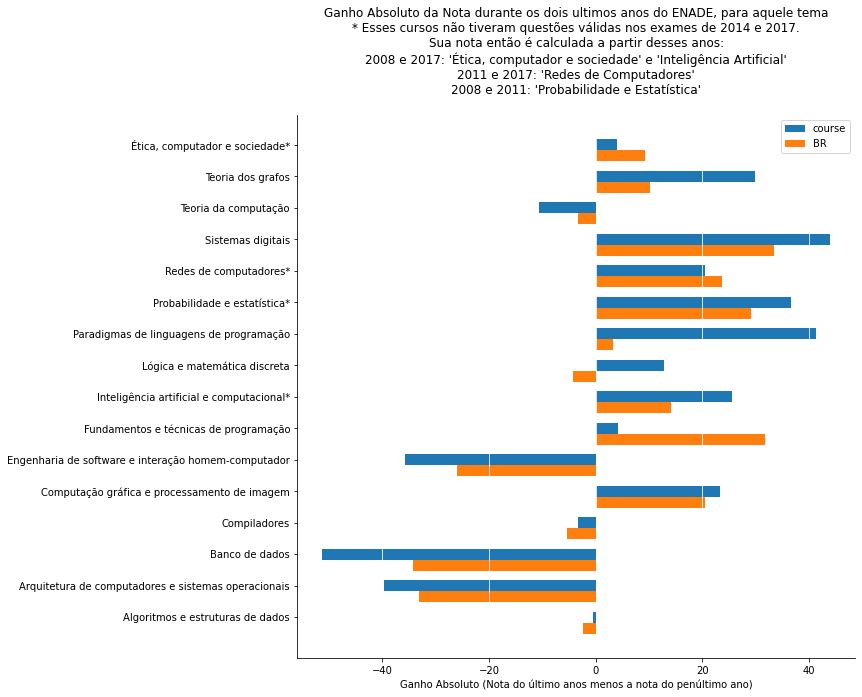

In [33]:
make_bar_gain_graph(df_score_by_year_course, df_score_by_year_br, "-", f"Ganho Absoluto da Nota durante os dois ultimos anos do ENADE, para aquele tema\n"
                                    f"* Esses cursos não tiveram questões válidas nos exames de 2014 e 2017.\n"
                                    f"Sua nota então é calculada a partir desses anos:\n"
                                    f"2008 e 2017: 'Ética, computador e sociedade' e 'Inteligência Artificial'\n"
                                    f"2011 e 2017: 'Redes de Computadores'\n"
                                    f"2008 e 2011: 'Probabilidade e Estatística'\n", 
                    "Ganho Absoluto (Nota do último anos menos a nota do penúltimo ano)")

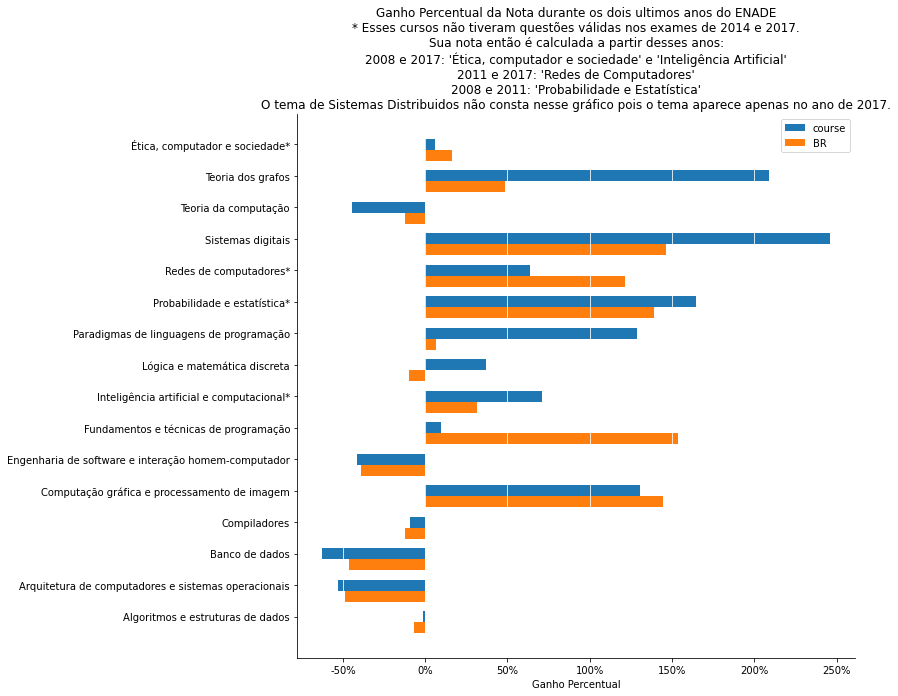

In [34]:
make_bar_gain_graph(df_score_by_year_course, df_score_by_year_br, "/", f"Ganho Percentual da Nota durante os dois ultimos anos do ENADE\n"
                                    f"* Esses cursos não tiveram questões válidas nos exames de 2014 e 2017.\n"
                                    f"Sua nota então é calculada a partir desses anos:\n"
                                    f"2008 e 2017: 'Ética, computador e sociedade' e 'Inteligência Artificial'\n"
                                    f"2011 e 2017: 'Redes de Computadores'\n"
                                    f"2008 e 2011: 'Probabilidade e Estatística'\n"
                                    f"O tema de Sistemas Distribuidos não consta nesse gráfico pois o tema aparece apenas no ano de 2017.",
                   "Ganho Percentual")

In [35]:
def get_max_score(course, br) -> Tuple[float, str]:
    if course >= br:
        return course, "course", "black"
    else:
        return br, "BR", "gray"
    
def get_min_score(course, br) -> Tuple[float, str]:
    if course < br:
        return course, "course", "black"
    else:
        return br, "BR", "gray"

In [36]:
def bar_grouped_graph_display_df(df_course, df_br, width=0.4):
    
    ax = plt.subplot(111)
    
    df_br = df_br.reindex_like(df_course)
    if not df_course.index.equals(df_br.index):
        raise ValueError("The indices of dataframes should be equal")
    
    
    course_score_series = df_course["Nota %"]
    br_score_series = df_br["Nota %"]
    
    merged_df = pd.DataFrame({"Nota % course": course_score_series,
                              "Nota % BR": br_score_series})
    
    merged_df["max"] = merged_df.max(axis=1)
    merged_df = merged_df.sort_values(by=["max"])
    labels = merged_df.index
    course_score_series = merged_df["Nota % course"]
    br_score_series = merged_df["Nota % BR"]

    x = np.arange(start=0, stop=len(labels), step=1)
    for i, score_course, score_br in zip(x, course_score_series, br_score_series):
        bigger_score, bigger_label, bigger_color = get_max_score(score_course, score_br)
        smaller_score, smaller_label, smaller_color = get_min_score(score_course, score_br)
        ax.barh(i + width, bigger_score, width, color=bigger_color)
        ax.barh(i, smaller_score, width, color=smaller_color)
    
    ax.grid(axis = 'x', color ='white', linestyle='-')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set(yticks=x + width, yticklabels=labels)#, ylim=[2*width - 1, len(df_course)])
    black_patch = mpatches.Patch(color='gray', label='BR')
    gray_patch = mpatches.Patch(color='black', label='course')
    plt.legend(handles=[gray_patch, black_patch])
    plt.title("Percentual de Acerto por Tema no ENADE")
    vals = ax.get_xticks()
    ax.set_xticklabels([f'{int(x)} %' for x in vals])
    #plt.xlabel("%")
    #plt.xlim(0, 100)
    plt.show()

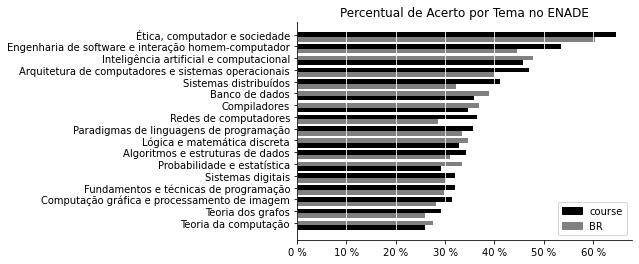

In [37]:
bar_grouped_graph_display_df(all_years_combined_subject_course, all_years_combined_subject_br)

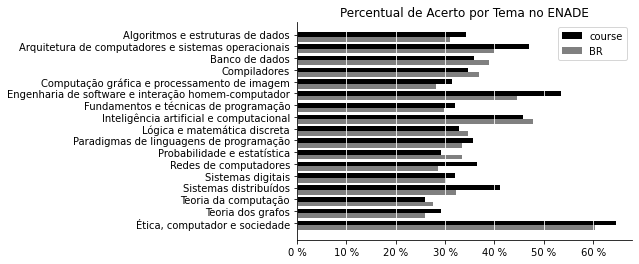

In [38]:
def bar_grouped_graph_display_df(df_course, df_br, width=0.4):
    
    ax = plt.subplot(111)
    
    df_br = df_br.reindex_like(df_course)
        
    course_score_series = df_course["Nota %"]
    br_score_series = df_br["Nota %"]
    
    merged_df = pd.DataFrame({"Nota % course": course_score_series,
                              "Nota % BR": br_score_series})
    
    merged_df = merged_df.sort_index(ascending=False)
    
    labels = merged_df.index
    course_score_series = merged_df["Nota % course"]
    br_score_series = merged_df["Nota % BR"]

    x = np.arange(start=0, stop=len(labels), step=1)
    ax.barh(x + width, course_score_series, width, color="black", label="course")
    ax.barh(x, br_score_series, width, color="gray", label = "BR")
    
    ax.grid(axis = 'x', color ='white', linestyle='-')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set(yticks=x + width, yticklabels=labels)#, ylim=[2*width - 1, len(df_course)])
    plt.legend()
    plt.title("Percentual de Acerto por Tema no ENADE")
    vals = ax.get_xticks()
    ax.set_xticklabels([f'{int(x)} %' for x in vals])
    #plt.xlabel("%")
    #plt.xlim(0, 100)
    plt.show()
    
bar_grouped_graph_display_df(all_years_combined_subject_course, all_years_combined_subject_br)

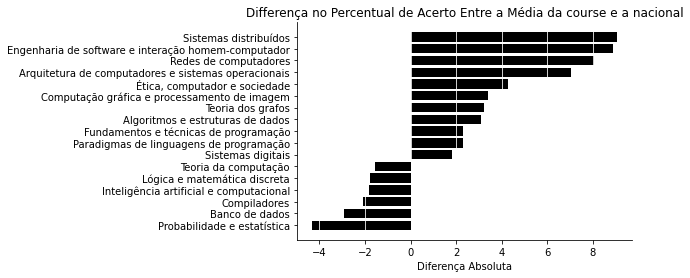

In [39]:
def bar_grouped_graph_display_df(df_course, df_br, title, operation, xlabel, width="0.4", vline=None):
    
    ax = plt.subplot(111)
    
    df_br = df_br.reindex_like(df_course)
    if not df_course.index.equals(df_br.index):
        raise ValueError("The indices of dataframes should be equal")
    
    
    course_score_series = df_course["Nota %"]
    br_score_series = df_br["Nota %"]
    
    merged_df = pd.DataFrame({"Nota % course": course_score_series,
                              "Nota % BR": br_score_series})
    
    if operation == "-":
        merged_df["diff"] = merged_df["Nota % course"] - merged_df["Nota % BR"]
    elif operation == "/":
        merged_df["diff"] = merged_df["Nota % course"] / merged_df["Nota % BR"]
    merged_df = merged_df.sort_values(by=["diff"])
    labels = merged_df.index

    ax.barh(labels, merged_df["diff"], color="black")

    
    ax.grid(axis = 'x', color ='white', linestyle='-')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    plt.title(title)
    if vline is not None:
        ax.axvline(x=vline,color="red")
    plt.xlabel(xlabel)
    vals = ax.get_xticks()
    #ax.set_xticklabels([f'{int(x)} %' for x in vals])
    #plt.xlabel("%")
    if operation == "/":
        plt.xlim(0.6, 1.4)
    plt.show()
title = "Differença no Percentual de Acerto Entre a Média da course e a nacional"    
bar_grouped_graph_display_df(all_years_combined_subject_course, all_years_combined_subject_br, title, "-", "Diferença Absoluta")

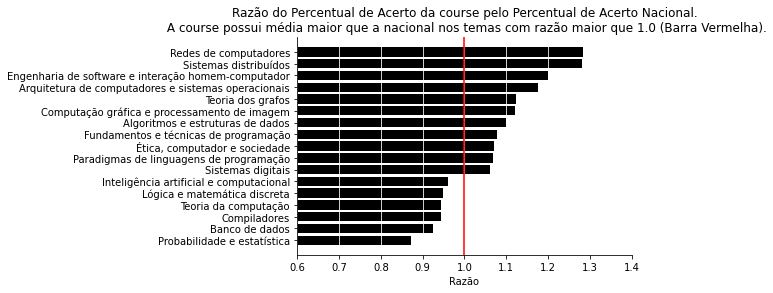

In [40]:
title = "Razão do Percentual de Acerto da course pelo Percentual de Acerto Nacional.\n A course possui média maior que a nacional nos temas com razão maior que 1.0 (Barra Vermelha)."
bar_grouped_graph_display_df(all_years_combined_subject_course, all_years_combined_subject_br, title, "/", "Razão", vline=1.0)

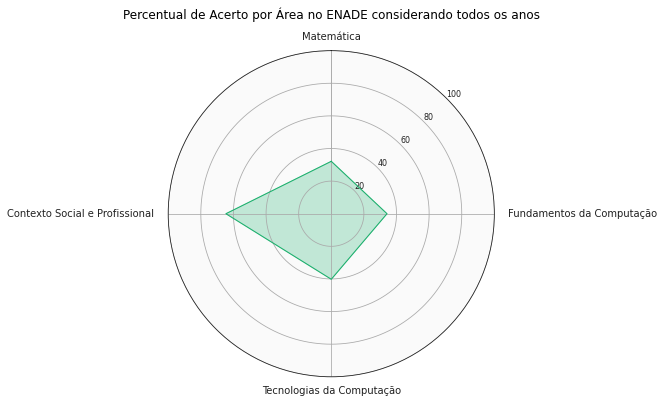

Dados da course


Matemática                        32.142857
Fundamentos da Computação         34.177215
Tecnologias da Computação         40.206186
Contexto Social e Profissional    64.615385
Name: Nota %, dtype: float64

In [41]:
def get_num_correct_poscomp_all_years(display_df: pd.DataFrame, subjects: list) -> int:
    result = 0
    for subject in subjects:
        if subject in display_df.index:
            result += display_df.loc[subject, "Acertos no Total (Acertos x Alunos)"]
    return result

def get_num_questions_poscomp_all_years(display_df: pd.DataFrame, subjects: list) -> int:
    result = 0
    for subject in subjects:
        if subject in display_df.index:
            result += display_df.loc[subject, "Questões Respondidas no total (Questões x Alunos)"]
    return result
    
def return_poscomp_score_all_years(display_df: pd.DataFrame):
    
    df = display_df.copy()
    
    # Add columns
    categories = [MATH_SUBJECTS, COMPUTING_SUBJECTS, TECHNOLOGY_SUBJECTS, HUMAN_SUBJECTS]
    labels = ["Matemática", "Fundamentos da Computação", "Tecnologias da Computação", 
              "Contexto Social e Profissional"]
    labels_with_questions = []
    for subjects, label in zip(categories, labels):
        
        # get score by student
        num_questions_subjects = get_num_questions_poscomp_all_years(display_df, subjects) 
        num_correct_subjects = get_num_correct_poscomp_all_years(display_df, subjects)
        score = (num_correct_subjects * 100) / num_questions_subjects
        
        new_dataframe = pd.DataFrame({"Questões Respondidas no total (Questões x Alunos)": num_questions_subjects,
                                      "Acertos no Total (Acertos x Alunos)": num_correct_subjects,
                                      "Nota %": score}, index=[label])
        df = df.append(new_dataframe)
        
    # return means core
    return df.loc[labels, "Nota %"]
poscomp_score_all_years_course = return_poscomp_score_all_years(all_years_combined_subject_course)
make_radar_plot(poscomp_score_all_years_course, "Percentual de Acerto por Área no ENADE considerando todos os anos")
print("Dados da course")
poscomp_score_all_years_course

In [42]:
def make_radar_plot_comparison(series_course, series_br, title):
    fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))
    colors = ['r', 'g']
    labels = ["course", "BR"]
    for series, color, label in zip([series_course, series_br], colors, labels):
        values = list(series.values)
        labels = list(series.index)


# Number of variables we're plotting.
        num_vars = len(labels)


# Split the circle into even parts and save the angles
# so we know where to put each axis.
        angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()

# The plot is a circle, so we need to "complete the loop"
# and append the start value to the end.
        values += values[:1]
        angles += angles[:1]

# ax = plt.subplot(polar=True)
    

# Draw the outline of our data.
        ax.plot(angles, values, color=color, label=label)
# Fill it in.
        ax.fill(angles, values, facecolor=color, alpha=0.1)

# Fix axis to go in the right order and start at 12 o'clock.
    ax.set_theta_offset(np.pi / 2)
    ax.set_theta_direction(-1)

# Draw axis lines for each angle and label.

    ax.set_thetagrids(np.degrees(angles), labels)

# Go through labels and adjust alignment based on where
# it is in the circle.
    for label, angle in zip(ax.get_xticklabels(), angles):
        if angle in (0, np.pi):
            label.set_horizontalalignment('center')
        elif 0 < angle < np.pi:
            label.set_horizontalalignment('left')
        else:
            label.set_horizontalalignment('right')

# Ensure radar goes from 0 to 100.
    #ax.set_ylim(0, 100)
# You can also set gridlines manually like this:
# ax.set_rgrids([20, 40, 60, 80, 100])

# Set position of y-labels (0-100) to be in the middle
# of the first two axes.
    ax.set_rlabel_position(180 / num_vars)

# Add some custom styling.
# Change the color of the tick labels.
    ax.tick_params(colors='#222222')
# Make the y-axis (0-100) labels smaller.
    ax.tick_params(axis='y', labelsize=8)
# Change the color of the circular gridlines.
    ax.grid(color='#AAAAAA')
# Change the color of the outermost gridline (the spine).
    ax.spines['polar'].set_color('#222222')
# Change the background color inside the circle itself.
    ax.set_facecolor('#FAFAFA')
    #legend = ax.legend(["course", "BR"], 
                       #labelspacing=0.1, fontsize='small')

# Lastly, give the chart a title and give it some
# padding above the "Acceleration" label.
    ax.set_title(title, y=1.08)
    plt.legend()
    plt.show()

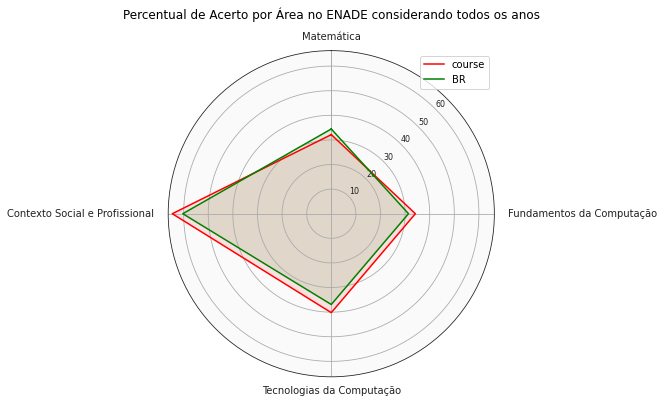

Matemática                        34.435474
Fundamentos da Computação         31.388764
Tecnologias da Computação         36.894791
Contexto Social e Profissional    60.349443
Name: Nota %, dtype: float64

In [43]:
poscomp_score_all_years_br = return_poscomp_score_all_years(all_years_combined_subject_br)
make_radar_plot_comparison(poscomp_score_all_years_course,
                           poscomp_score_all_years_br, 
                           "Percentual de Acerto por Área no ENADE considerando todos os anos")
poscomp_score_all_years_br

In [44]:
validity_csv = util.get_validity_questions_df_all_years(subject_df, dfs_dict_course)
validity_csv["soma"] = validity_csv.sum(axis=1)
validity_csv = validity_csv.sort_values(["soma", "valid"])


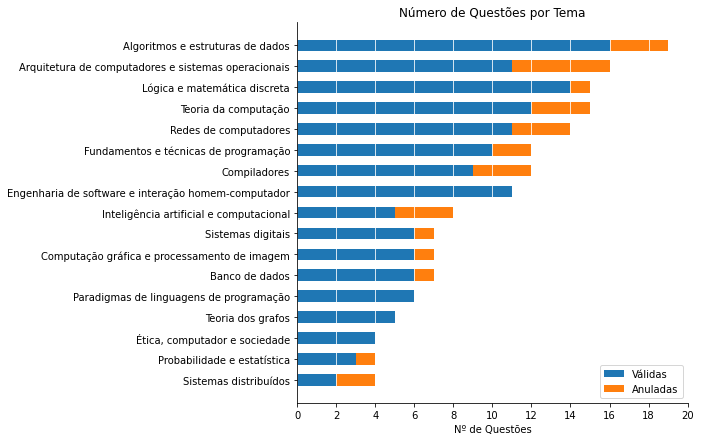

In [45]:

labels = validity_csv.index
width = 0.55       # the width of the bars: can also be len(x) sequence

fig, ax = plt.subplots(figsize=(7,7))

ax.barh(labels, validity_csv["valid"], width, label='Válidas')
ax.barh(labels, validity_csv["invalid"], width, left=validity_csv["valid"], label='Anuladas')

plt.xlabel("Nº de Questões")
ax.set_title('Número de Questões por Tema')
plt.xticks(range(0, 21,2))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.grid(axis = 'x', color ='white', linestyle='-')


ax.legend()
plt.show()